# Setup

In [1]:
import os
import numpy as np
import rasterio
import geopandas as gpd
from rasterio import features
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from tqdm import tqdm
from rasterio.warp import reproject, Resampling
import glob
import sys

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Python:", sys.executable)
print("torch.__version__:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())

Python: /usr/bin/python3
torch.__version__: 2.9.0+cu126
torch.version.cuda: 12.6
cuda available: True


In [3]:
!nvidia-smi


Tue Dec  2 13:24:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
def load_raster(path):
    """Load raster and return array + profile."""
    src = rasterio.open(path)
    arr = src.read(1)
    profile = src.profile
    return arr, profile

def save_raster(path, array, profile):
    """Save raster with given profile."""
    profile.update(dtype=rasterio.uint8, count=1)
    with rasterio.open(path, "w", **profile) as dst:
        dst.write(array.astype("uint8"), 1)

def rasterize_shapefile(gdf, reference_profile, attribute):
    """Rasterize shapefile according to reference raster."""
    shapes = [(geom, value) for geom, value in zip(gdf.geometry, gdf[attribute])]
    raster = features.rasterize(
        shapes=shapes,
        out_shape=(reference_profile["height"], reference_profile["width"]),
        transform=reference_profile["transform"],
        fill=0,
        dtype="uint8"
    )
    return raster

# Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BASE_DIR = r"/content/drive/MyDrive/12-training-data"

# Feature rasters live directly inside BASE_DIR
FEATURE_DIR = os.path.join(BASE_DIR, "input")
OUTPUT_DIR = os.path.join(BASE_DIR, "output")

DEPENDENT_DIR = os.path.join(FEATURE_DIR, "dependent-data-urban-no")
LANDCOVER_DIR = os.path.join(FEATURE_DIR, "final-data-land-cover")


In [6]:
rasters_2019 = {
    "NDVI": os.path.join(FEATURE_DIR, "NDVI_2019.tif"),
    "NDBI": os.path.join(FEATURE_DIR, "NDBI_2019.tif"),
    "MNDWI": os.path.join(FEATURE_DIR, "MNDWI_2019.tif"),
    "BSI": os.path.join(FEATURE_DIR, "BSI_2019.tif"),
    "DEM": os.path.join(FEATURE_DIR, "DEM-DAegu-merged-clipmask.tif"),
    "slope": os.path.join(FEATURE_DIR, "slope.tif"),
    "hillshade": os.path.join(FEATURE_DIR, "hillshade.tif"),
    "night": os.path.join(FEATURE_DIR, "VNL_2019_daegu_clipped.tif"),
    "ecology": os.path.join(FEATURE_DIR, "env-assessment-data-2019.tif"),
}

In [7]:
feature_arrays = {}
feature_profiles = {}

print("Loading 2019 rasters...\n")

for name, path in rasters_2019.items():
    arr, profile = load_raster(path)
    feature_arrays[name] = arr
    feature_profiles[name] = profile
    print(f"{name} loaded → shape: {arr.shape}")


Loading 2019 rasters...

NDVI loaded → shape: (4531, 3714)
NDBI loaded → shape: (4531, 3714)
MNDWI loaded → shape: (4531, 3714)
BSI loaded → shape: (4531, 3714)
DEM loaded → shape: (1622, 1330)
slope loaded → shape: (1622, 1330)
hillshade loaded → shape: (1622, 1330)
night loaded → shape: (99, 100)
ecology loaded → shape: (4590, 3684)


In [9]:
urb19_path = os.path.join(DEPENDENT_DIR, "landcover_2019_urban_binary.shp")
urb24_path = os.path.join(DEPENDENT_DIR, "landcover_2024_urban_binary.shp")

gdf_urb19 = gpd.read_file(urb19_path)
gdf_urb24 = gpd.read_file(urb24_path)

print("Urban 2019 polygons:", len(gdf_urb19))
print("Urban 2024 polygons:", len(gdf_urb24))

KeyboardInterrupt: 

In [ ]:
lc19_path = os.path.join(LANDCOVER_DIR, "landcover_2019_final.shp")
lc24_path = os.path.join(LANDCOVER_DIR, "landcover_2024_final.shp")

gdf_lc19 = gpd.read_file(lc19_path)
gdf_lc24 = gpd.read_file(lc24_path)

print("Landcover 2019 classes:", len(gdf_lc19))
print("Landcover 2024 classes:", len(gdf_lc24))

In [ ]:
reference_profile = feature_profiles["NDVI"]
print("\nReference raster info:")
print("  Size:", reference_profile["height"], "x", reference_profile["width"])
print("  CRS:", reference_profile["crs"])
print("  Resolution:", reference_profile["transform"][0])

# Rasterize urban shapefile

In [ ]:
urban_2019_raster_path = os.path.join(DEPENDENT_DIR, "urban_2019.tif")
urban_2024_raster_path = os.path.join(DEPENDENT_DIR, "urban_2024.tif")

In [ ]:
# Reproject urban shapefile to match raster CRS
target_crs = reference_profile["crs"]

gdf_urb19 = gdf_urb19.to_crs(target_crs)
gdf_urb24 = gdf_urb24.to_crs(target_crs)

print("Reprojection complete.")

In [ ]:
urban2019_raster = rasterize_shapefile(
    gdf=gdf_urb19,
    reference_profile=reference_profile,
    attribute="UrbanBinar"
)

save_raster(urban_2019_raster_path, urban2019_raster, reference_profile)

In [ ]:
gdf_urb19.columns

In [ ]:
urban2024_raster = rasterize_shapefile(
    gdf=gdf_urb24,
    reference_profile=reference_profile,
    attribute="UrbanBinar"
)

save_raster(urban_2024_raster_path, urban2024_raster, reference_profile)


In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(urban2019_raster, cmap="gray")
plt.title("Urban 2019 (0 = Non-urban, 1 = Urban)")
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(urban2024_raster, cmap="gray")
plt.title("Urban 2024 (0 = Non-urban, 1 = Urban)")
plt.colorbar()
plt.show()

In [ ]:
print(reference_profile["crs"])
print(gdf_urb19.crs)

In [ ]:
gdf_urb19.columns
gdf_urb19.head()

In [8]:
# Paths
urban19_path = os.path.join(DEPENDENT_DIR, "urban_2019.tif")
urban24_path = os.path.join(DEPENDENT_DIR, "urban_2024.tif")

# Load both rasters
with rasterio.open(urban19_path) as src19:
    u19 = src19.read(1)
    profile = src19.profile

with rasterio.open(urban24_path) as src24:
    u24 = src24.read(1)

# Create output label array
label = np.zeros_like(u19, dtype=np.uint8)

# 1 = became urban (2019 nonurban → 2024 urban)
label[(u19 == 0) & (u24 == 1)] = 1

# 0 = stayed nonurban (2019 nonurban → 2024 nonurban)
label[(u19 == 0) & (u24 == 0)] = 0

# 255 = ignore (urban already in 2019, or urban→nonurban)
label[(u19 == 1)] = 255

# Save output
profile.update(dtype=rasterio.uint8, nodata=255)

output_path = os.path.join(DEPENDENT_DIR, "urban_no_urban.tif")
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(label, 1)

print("Saved:", output_path)


Saved: /content/drive/MyDrive/12-training-data/input/dependent-data-urban-no/urban_no_urban.tif


In [9]:
unique, counts = np.unique(label, return_counts=True)
print(list(zip(unique, counts)))

[(np.uint8(0), np.int64(14286520)), (np.uint8(1), np.int64(265903)), (np.uint8(255), np.int64(2275711))]


# Resampling, reproject

In [10]:
reference_profile = feature_profiles["NDVI"]
ref_crs = reference_profile["crs"]
ref_res = reference_profile["transform"][0]
ref_width, ref_height = reference_profile["width"], reference_profile["height"]
ref_bounds = rasterio.open(rasters_2019["NDVI"]).bounds

print("REFERENCE NDVI:")
print("  CRS:", ref_crs)
print("  Res:", ref_res)
print("  Size:", ref_height, "x", ref_width)
print("  Bounds:", ref_bounds)
print("--------------------------------------------------")

for name, path in rasters_2019.items():
    with rasterio.open(path) as src:
        print(f"Raster: {name}")
        print("  CRS:", src.crs)
        print("  Res:", src.res)
        print("  Size:", src.height, "x", src.width)
        print("  Bounds:", src.bounds)
        print("  SAME CRS?", src.crs == ref_crs)
        print("  SAME RES?", src.res[0] == ref_res)
        print("  SAME SIZE?", (src.height == ref_height) and (src.width == ref_width))
        print("--------------------------------------------------")


REFERENCE NDVI:
  CRS: EPSG:32652
  Res: 10.0
  Size: 4531 x 3714
  Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
--------------------------------------------------
Raster: NDVI
  CRS: EPSG:32652
  Res: (10.0, 10.0)
  Size: 4531 x 3714
  Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
  SAME CRS? True
  SAME RES? True
  SAME SIZE? True
--------------------------------------------------
Raster: NDBI
  CRS: EPSG:32652
  Res: (10.0, 10.0)
  Size: 4531 x 3714
  Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
  SAME CRS? True
  SAME RES? True
  SAME SIZE? True
--------------------------------------------------
Raster: MNDWI
  CRS: EPSG:32652
  Res: (10.0, 10.0)
  Size: 4531 x 3714
  Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
  SAME CRS? True
  SAME RES? True
  SAME SIZE? True
--------------------------------------------------
Raster: BSI
  CR

In [11]:
def align_to_reference(src_path, ref_profile):
    with rasterio.open(src_path) as src:
        data = src.read(1)

        # Prepare empty destination array
        dst_arr = np.zeros((ref_profile["height"], ref_profile["width"]), dtype=np.float32)

        reproject(
            source=data,
            destination=dst_arr,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_profile["transform"],
            dst_crs=ref_profile["crs"],
            resampling=Resampling.bilinear
        )

        return dst_arr

In [12]:
aligned_DEM = align_to_reference(rasters_2019["DEM"], reference_profile)
aligned_slope = align_to_reference(rasters_2019["slope"], reference_profile)
aligned_hillshade = align_to_reference(rasters_2019["hillshade"], reference_profile)

In [13]:
aligned_ecology = align_to_reference(rasters_2019["ecology"], reference_profile)


In [14]:
aligned_night = align_to_reference(rasters_2019["night"], reference_profile)


In [16]:
aligned_arrays = {
    "NDVI": feature_arrays["NDVI"],     # original NDVI
    "NDBI": feature_arrays["NDBI"],
    "MNDWI": feature_arrays["MNDWI"],
    "BSI": feature_arrays["BSI"],

    "DEM": aligned_DEM,
    "slope": aligned_slope,
    "hillshade": aligned_hillshade,
    "night": aligned_night,
    "ecology": aligned_ecology,
}


In [17]:
for name, arr in aligned_arrays.items():
    print(name, arr.shape)

NDVI (4531, 3714)
NDBI (4531, 3714)
MNDWI (4531, 3714)
BSI (4531, 3714)
DEM (4531, 3714)
slope (4531, 3714)
hillshade (4531, 3714)
night (4531, 3714)
ecology (4531, 3714)


# Stacked Array

In [18]:


# normalization
def normalize(arr):
    """Min-max normalize array to 0–1."""
    arr = arr.astype(np.float32)
    mn, mx = np.nanmin(arr), np.nanmax(arr)
    if mx - mn == 0:
        return np.zeros_like(arr)
    return (arr - mn) / (mx - mn)

#normalize all aligned feature
normalized_features = {}
for name, arr in aligned_arrays.items():
    norm_arr = normalize(arr)
    normalized_features[name] = norm_arr
    print(f"{name:12} normalized → min={norm_arr.min():.3f}, max={norm_arr.max():.3f}")

print("\nAll features normalized.\n")

# load dependent label raster (urban/no urban)
label_path = os.path.join(DEPENDENT_DIR, "urban_no_urban.tif")

with rasterio.open(label_path) as src:
    y = src.read(1)
    label_nodata = src.nodata
    print("Label shape:", y.shape)
    print("Label nodata:", label_nodata)

# Create valid mask (True = usable pixel)
if label_nodata is None:
    label_mask = np.ones_like(y, dtype=bool)
else:
    label_mask = (y != label_nodata)

# ----------------------------------------------------
# 4. STACK FEATURES INTO X (H, W, C)
# ----------------------------------------------------
feature_list = []
feature_names = []

for name, arr in normalized_features.items():
    feature_list.append(arr)
    feature_names.append(name)

# Stack: output shape (H, W, C)
X = np.stack(feature_list, axis=-1)

print("\n====================")
print("STACKED ARRAY READY!")
print("====================")
print("X shape:", X.shape)         # (H, W, C)
print("y shape:", y.shape)         # (H, W)
print("Feature order:", feature_names)

# Optional: mask for pixel-level ML (not needed for UNet)
X_masked = X[label_mask]
y_masked = y[label_mask]

print("\nMasked X shape:", X_masked.shape)
print("Masked y shape:", y_masked.shape)

NDVI         normalized → min=0.000, max=1.000
NDBI         normalized → min=0.000, max=1.000
MNDWI        normalized → min=0.000, max=1.000
BSI          normalized → min=0.000, max=1.000
DEM          normalized → min=0.000, max=1.000
slope        normalized → min=0.000, max=1.000
hillshade    normalized → min=0.000, max=1.000
night        normalized → min=0.000, max=1.000
ecology      normalized → min=0.000, max=1.000

All features normalized.

Label shape: (4531, 3714)
Label nodata: 255.0

STACKED ARRAY READY!
X shape: (4531, 3714, 9)
y shape: (4531, 3714)
Feature order: ['NDVI', 'NDBI', 'MNDWI', 'BSI', 'DEM', 'slope', 'hillshade', 'night', 'ecology']

Masked X shape: (14552423, 9)
Masked y shape: (14552423,)


# Patch Extraction Code

In [19]:
PATCH_SIZE = 64
STRIDE = 32

X = X  # your stacked array from Step 2
y = y  # your label raster

# Where to save patches
PATCH_DIR = os.path.join(BASE_DIR, "patches")
os.makedirs(PATCH_DIR, exist_ok=True)
os.makedirs(os.path.join(PATCH_DIR, "X"), exist_ok=True)
os.makedirs(os.path.join(PATCH_DIR, "y"), exist_ok=True)

h, w, c = X.shape
print("Raster size:", h, w)
print("Channels:", c)

patch_id = 0

for row in tqdm(range(0, h - PATCH_SIZE, STRIDE)):
    for col in range(0, w - PATCH_SIZE, STRIDE):

        X_patch = X[row:row+PATCH_SIZE, col:col+PATCH_SIZE, :]
        y_patch = y[row:row+PATCH_SIZE, col:col+PATCH_SIZE]

        # Skip patches where all labels are 255
        if np.all(y_patch == 255):
            continue

        # Optional: keep all patches that contain ANY urbanization (label=1)
        # This improves class balance
        if (1 in y_patch):
            pass  # keep
        else:
            # Keep only 20% of negative patches (random sampling)
            if np.random.rand() > 0.20:
                continue

        # Save patch
        np.save(os.path.join(PATCH_DIR, "X", f"X_{patch_id}.npy"), X_patch)
        np.save(os.path.join(PATCH_DIR, "y", f"y_{patch_id}.npy"), y_patch)

        patch_id += 1

print("Total patches saved:", patch_id)


Raster size: 4531 3714
Channels: 9


100%|██████████| 140/140 [05:22<00:00,  2.30s/it]

Total patches saved: 10850


In [33]:
BASE_DIR = r"/content/drive/MyDrive/12-training-data"
PATCH_DIR = os.path.join(BASE_DIR, "patches")   # PATCH_SIZE = 64
PATCH_SIZE = 64
BATCH_SIZE = 8
EPOCHS = 30

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

NUM_FEATURE_BANDS = 9
MODEL_OUT = os.path.join(BASE_DIR, "models")
os.makedirs(MODEL_OUT, exist_ok=True)

DEVICE: cuda


In [31]:
class PatchDataset(Dataset):
    def __init__(self, x_files, y_files, augment=True):
        self.x_files = x_files
        self.y_files = y_files
        self.augment = augment

    def __len__(self):
        return len(self.x_files)

    def __getitem__(self, idx):
        x = np.load(self.x_files[idx]).astype(np.float32)      # (H, W, C)
        y = np.load(self.y_files[idx]).astype(np.uint8)        # (H, W)

        x = torch.from_numpy(x).permute(2, 0, 1)               # -> (C, H, W)
        y = torch.from_numpy(y).float().unsqueeze(0)           # -> (1, H, W)

        # clamp ignore 255 → 0 because DL expects 0/1
        y = torch.clamp(y, 0, 1)

        if self.augment:
            x, y = self._augment(x, y)

        return x, y

    def _augment(self, x, y):
        if np.random.rand() > 0.5:
            x = TF.hflip(x); y = TF.hflip(y)
        if np.random.rand() > 0.5:
            x = TF.vflip(x); y = TF.vflip(y)
        k = np.random.randint(4)
        if k:
            x = torch.rot90(x, k, [1,2])
            y = torch.rot90(y, k, [1,2])
        return x, y

In [27]:
# -----------------------
# UNet Model
# -----------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=9, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Downsampling layers
        for feat in features:
            self.downs.append(ConvBlock(in_channels, feat))
            in_channels = feat

        # Bottleneck
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)

        # Upsampling layers
        for feat in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feat*2, feat, kernel_size=2, stride=2))
            self.ups.append(ConvBlock(feat*2, feat))

        self.pool = nn.MaxPool2d(2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Down path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Up path
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                skip = TF.center_crop(skip, (x.shape[2], x.shape[3]))
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)

In [28]:
# -----------------------
# LOSS FUNCTIONS
# -----------------------
def dice_loss(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - (2*intersection + eps) / (union + eps)


class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        loss_bce = self.bce(logits, targets)
        loss_dice = dice_loss(logits, targets)
        return loss_bce + loss_dice

In [36]:
# -----------------------
# LOAD PATCHES
# -----------------------
x_files = sorted(glob.glob(os.path.join(PATCH_DIR, "X", "*.npy")))
y_files = sorted(glob.glob(os.path.join(PATCH_DIR, "y", "*.npy")))

print("Total patches found:", len(x_files))

train_x, val_x, train_y, val_y = train_test_split(
    x_files, y_files, test_size=0.10, random_state=42
)

train_ds = PatchDataset(train_x, train_y, augment=True)
val_ds   = PatchDataset(val_x, val_y, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")

Total patches found: 10850
Train: 9765, Val: 1085


In [37]:
# -----------------------
# TRAINING SETUP
# -----------------------
model = UNet(in_channels=NUM_FEATURE_BANDS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = BCEDiceLoss()

best_f1 = 0.0

In [39]:
# -----------------------
# TRAINING LOOP
# -----------------------
def threshold_logits(logits, thresh=0.5):
    return (torch.sigmoid(logits) > thresh).float()


for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_ds)

    # -----------------------
    # VALIDATION
    # -----------------------
    model.eval()
    val_loss = 0
    tp=fp=fn=tn=0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)

            preds = threshold_logits(logits)

            # Flatten
            preds_f = preds.view(-1)
            yb_f = yb.view(-1)

            tp += ((preds_f==1) & (yb_f==1)).sum().item()
            tn += ((preds_f==0) & (yb_f==0)).sum().item()
            fp += ((preds_f==1) & (yb_f==0)).sum().item()
            fn += ((preds_f==0) & (yb_f==1)).sum().item()

    val_loss /= len(val_ds)
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)
    acc       = (tp + tn) / (tp + tn + fp + fn + 1e-9)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"P: {precision:.3f} R: {recall:.3f} F1: {f1:.3f} Acc: {acc:.3f}")

    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        ckpt = os.path.join(MODEL_OUT, f"unet_best_f1_{best_f1:.4f}.pth")
        torch.save(model.state_dict(), ckpt)
        print("Saved:", ckpt)

print("Training finished. Best F1:", best_f1)

Epoch 1/30: 100%|██████████| 1221/1221 [05:30<00:00,  3.69it/s]


Epoch 1 | Train Loss: 0.7723 | Val Loss: 0.6464 | P: 0.840 R: 0.729 F1: 0.781 Acc: 0.903
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.7807.pth


Epoch 2/30: 100%|██████████| 1221/1221 [01:16<00:00, 16.03it/s]


Epoch 2 | Train Loss: 0.6351 | Val Loss: 0.6015 | P: 0.858 R: 0.745 F1: 0.798 Acc: 0.911
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.7979.pth


Epoch 3/30: 100%|██████████| 1221/1221 [01:16<00:00, 15.99it/s]


Epoch 3 | Train Loss: 0.6038 | Val Loss: 0.5866 | P: 0.859 R: 0.750 F1: 0.801 Acc: 0.912
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8008.pth


Epoch 4/30: 100%|██████████| 1221/1221 [01:16<00:00, 16.05it/s]


Epoch 4 | Train Loss: 0.5885 | Val Loss: 0.6238 | P: 0.905 R: 0.694 F1: 0.785 Acc: 0.911


Epoch 5/30: 100%|██████████| 1221/1221 [01:17<00:00, 15.77it/s]


Epoch 5 | Train Loss: 0.5904 | Val Loss: 0.5894 | P: 0.882 R: 0.734 F1: 0.801 Acc: 0.914
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8010.pth


Epoch 6/30: 100%|██████████| 1221/1221 [01:17<00:00, 15.76it/s]


Epoch 6 | Train Loss: 0.5741 | Val Loss: 0.6572 | P: 0.896 R: 0.670 F1: 0.767 Acc: 0.904


Epoch 7/30: 100%|██████████| 1221/1221 [01:20<00:00, 15.24it/s]


Epoch 7 | Train Loss: 0.5659 | Val Loss: 0.5721 | P: 0.877 R: 0.744 F1: 0.805 Acc: 0.915
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8050.pth


Epoch 8/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.09it/s]


Epoch 8 | Train Loss: 0.5605 | Val Loss: 0.5727 | P: 0.890 R: 0.737 F1: 0.806 Acc: 0.917
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8062.pth


Epoch 9/30: 100%|██████████| 1221/1221 [01:16<00:00, 16.00it/s]


Epoch 9 | Train Loss: 0.5636 | Val Loss: 0.6066 | P: 0.887 R: 0.712 F1: 0.790 Acc: 0.911


Epoch 10/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.12it/s]


Epoch 10 | Train Loss: 0.5527 | Val Loss: 0.5783 | P: 0.908 R: 0.722 F1: 0.805 Acc: 0.917


Epoch 11/30: 100%|██████████| 1221/1221 [01:16<00:00, 16.02it/s]


Epoch 11 | Train Loss: 0.5564 | Val Loss: 0.5787 | P: 0.902 R: 0.722 F1: 0.802 Acc: 0.916


Epoch 12/30: 100%|██████████| 1221/1221 [01:17<00:00, 15.83it/s]


Epoch 12 | Train Loss: 0.5581 | Val Loss: 0.5561 | P: 0.888 R: 0.748 F1: 0.812 Acc: 0.918
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8120.pth


Epoch 13/30: 100%|██████████| 1221/1221 [01:16<00:00, 15.99it/s]


Epoch 13 | Train Loss: 0.5493 | Val Loss: 0.5748 | P: 0.907 R: 0.719 F1: 0.802 Acc: 0.916


Epoch 14/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.21it/s]


Epoch 14 | Train Loss: 0.5376 | Val Loss: 0.5536 | P: 0.888 R: 0.748 F1: 0.812 Acc: 0.918


Epoch 15/30: 100%|██████████| 1221/1221 [01:14<00:00, 16.32it/s]


Epoch 15 | Train Loss: 0.5419 | Val Loss: 0.5450 | P: 0.895 R: 0.749 F1: 0.816 Acc: 0.920
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8158.pth


Epoch 16/30: 100%|██████████| 1221/1221 [01:16<00:00, 16.04it/s]


Epoch 16 | Train Loss: 0.5373 | Val Loss: 0.5349 | P: 0.860 R: 0.783 F1: 0.819 Acc: 0.919
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8193.pth


Epoch 17/30: 100%|██████████| 1221/1221 [01:17<00:00, 15.85it/s]


Epoch 17 | Train Loss: 0.5327 | Val Loss: 0.5413 | P: 0.886 R: 0.758 F1: 0.817 Acc: 0.920


Epoch 18/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.22it/s]


Epoch 18 | Train Loss: 0.5332 | Val Loss: 0.5395 | P: 0.854 R: 0.784 F1: 0.817 Acc: 0.918


Epoch 19/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.08it/s]


Epoch 19 | Train Loss: 0.5346 | Val Loss: 0.5502 | P: 0.882 R: 0.756 F1: 0.814 Acc: 0.919


Epoch 20/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.19it/s]


Epoch 20 | Train Loss: 0.5358 | Val Loss: 0.5381 | P: 0.876 R: 0.771 F1: 0.820 Acc: 0.920
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8199.pth


Epoch 21/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.11it/s]


Epoch 21 | Train Loss: 0.5285 | Val Loss: 0.5373 | P: 0.890 R: 0.759 F1: 0.820 Acc: 0.921


Epoch 22/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.09it/s]


Epoch 22 | Train Loss: 0.5296 | Val Loss: 0.5348 | P: 0.883 R: 0.764 F1: 0.820 Acc: 0.921


Epoch 23/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.21it/s]


Epoch 23 | Train Loss: 0.5245 | Val Loss: 0.5415 | P: 0.889 R: 0.756 F1: 0.817 Acc: 0.920


Epoch 24/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.26it/s]


Epoch 24 | Train Loss: 0.5217 | Val Loss: 0.5292 | P: 0.874 R: 0.775 F1: 0.822 Acc: 0.921
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8215.pth


Epoch 25/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.12it/s]


Epoch 25 | Train Loss: 0.5210 | Val Loss: 0.5365 | P: 0.883 R: 0.765 F1: 0.819 Acc: 0.921


Epoch 26/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.09it/s]


Epoch 26 | Train Loss: 0.5268 | Val Loss: 0.5353 | P: 0.897 R: 0.756 F1: 0.820 Acc: 0.922


Epoch 27/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.24it/s]


Epoch 27 | Train Loss: 0.5227 | Val Loss: 0.5394 | P: 0.901 R: 0.748 F1: 0.818 Acc: 0.921


Epoch 28/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.25it/s]


Epoch 28 | Train Loss: 0.5172 | Val Loss: 0.5249 | P: 0.879 R: 0.774 F1: 0.823 Acc: 0.922
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8232.pth


Epoch 29/30: 100%|██████████| 1221/1221 [01:15<00:00, 16.14it/s]


Epoch 29 | Train Loss: 0.5191 | Val Loss: 0.5250 | P: 0.861 R: 0.788 F1: 0.823 Acc: 0.920


Epoch 30/30: 100%|██████████| 1221/1221 [01:17<00:00, 15.70it/s]


Epoch 30 | Train Loss: 0.5226 | Val Loss: 0.5179 | P: 0.879 R: 0.780 F1: 0.826 Acc: 0.923
Saved: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8263.pth
Training finished. Best F1: 0.8263316448701974


In [40]:
ckpts = sorted(glob.glob(os.path.join(MODEL_OUT, "*.pth")))
ckpts

['/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.7807.pth',
 '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.7979.pth',
 '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8008.pth',
 '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8010.pth',
 '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8050.pth',
 '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8062.pth',
 '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8120.pth',
 '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8158.pth',
 '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8193.pth',
 '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8199.pth',
 '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8215.pth',
 '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8232.pth',
 '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8263.pth']

In [41]:
history = {
    "checkpoint": [],
    "f1": [],
    "precision": [],
    "recall": [],
    "acc": [],
    "val_loss": []
}

def threshold_logits(logits, thresh=0.5):
    return (torch.sigmoid(logits) > thresh).float()

model = UNet(in_channels=NUM_FEATURE_BANDS).to(DEVICE)

for ckpt in ckpts:
    print("Validating:", ckpt)
    model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
    model.eval()

    val_loss = 0
    tp=fp=fn=tn=0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)

            preds = threshold_logits(logits)
            preds_f = preds.view(-1)
            yb_f = yb.view(-1)

            tp += ((preds_f==1) & (yb_f==1)).sum().item()
            tn += ((preds_f==0) & (yb_f==0)).sum().item()
            fp += ((preds_f==1) & (yb_f==0)).sum().item()
            fn += ((preds_f==0) & (yb_f==1)).sum().item()

    val_loss /= len(val_ds)
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)
    acc       = (tp + tn) / (tp + tn + fp + fn + 1e-9)

    history["checkpoint"].append(os.path.basename(ckpt))
    history["f1"].append(f1)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["acc"].append(acc)
    history["val_loss"].append(val_loss)


Validating: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.7807.pth
Validating: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.7979.pth
Validating: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8008.pth
Validating: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8010.pth
Validating: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8050.pth
Validating: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8062.pth
Validating: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8120.pth
Validating: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8158.pth
Validating: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8193.pth
Validating: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8199.pth
Validating: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8215.pth
Validating: /content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8232.pth
Vali

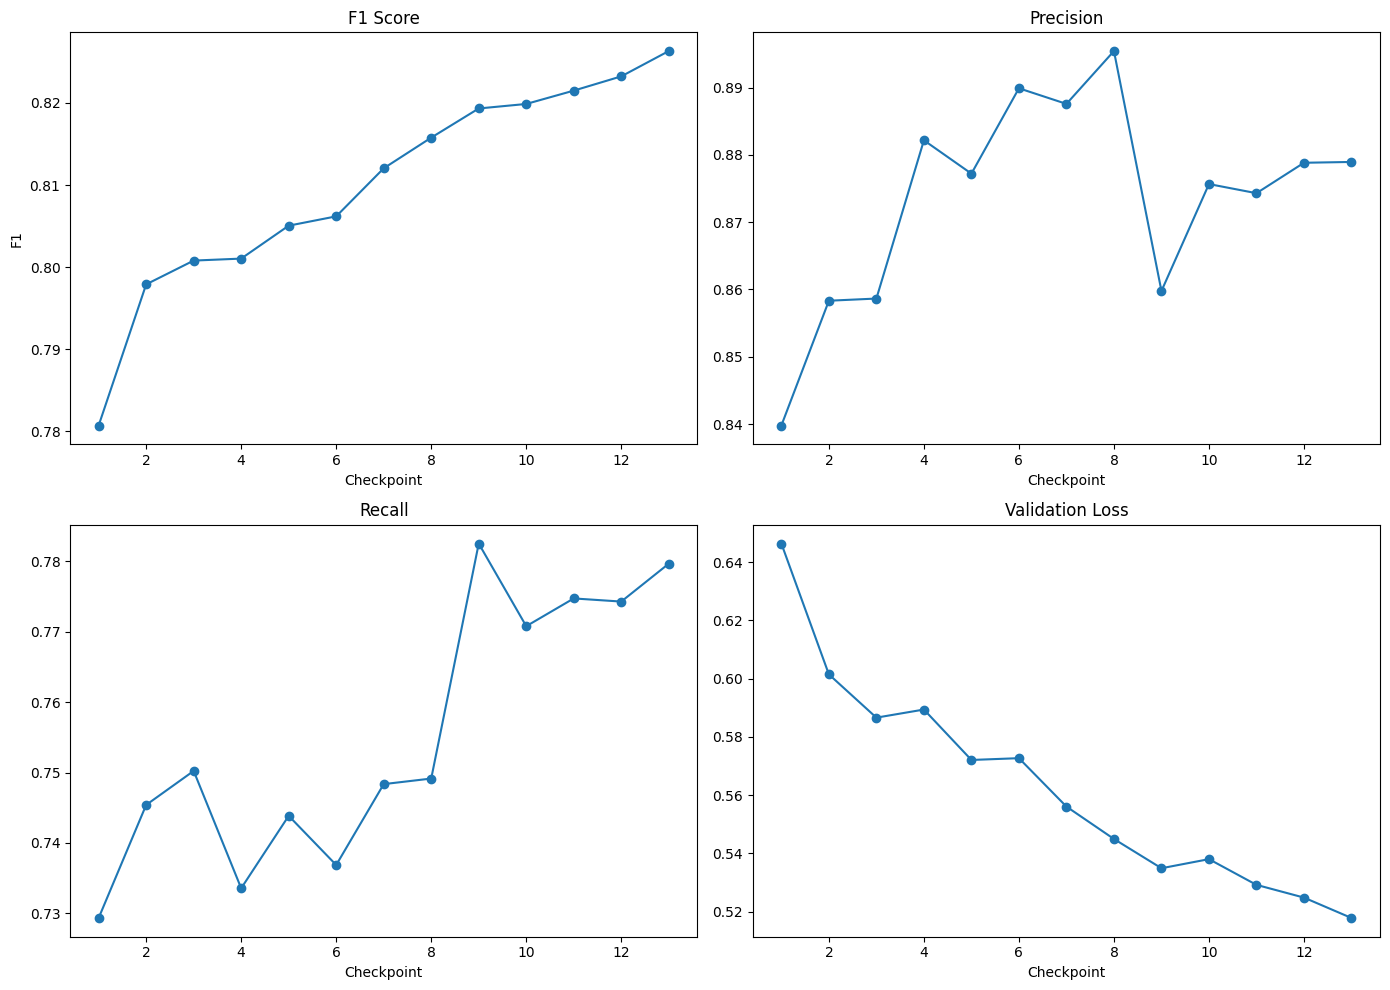

In [42]:
plt.figure(figsize=(14,10))

epochs = range(1, len(history["f1"]) + 1)

# F1
plt.subplot(2,2,1)
plt.plot(epochs, history["f1"], marker='o')
plt.title("F1 Score")
plt.xlabel("Checkpoint")
plt.ylabel("F1")

# Precision
plt.subplot(2,2,2)
plt.plot(epochs, history["precision"], marker='o')
plt.title("Precision")
plt.xlabel("Checkpoint")

# Recall
plt.subplot(2,2,3)
plt.plot(epochs, history["recall"], marker='o')
plt.title("Recall")
plt.xlabel("Checkpoint")

# Val Loss
plt.subplot(2,2,4)
plt.plot(epochs, history["val_loss"], marker='o')
plt.title("Validation Loss")
plt.xlabel("Checkpoint")

plt.tight_layout()
plt.show()

# Full Raster Inference

In [44]:
MODEL_PATH = "/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8232.pth"
DEVICE = torch.device("cuda")

# Load model
model = UNet(in_channels=NUM_FEATURE_BANDS).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

print("Model loaded")


Model loaded


In [45]:
X.shape = (4531, 3714, 9)

In [46]:
H, W, C = X.shape
PATCH_SIZE = 64
STRIDE = 32

prob_map = np.zeros((H, W), dtype=np.float32)
count_map = np.zeros((H, W), dtype=np.float32)

for row in tqdm(range(0, H - PATCH_SIZE + 1, STRIDE)):
    for col in range(0, W - PATCH_SIZE + 1, STRIDE):

        patch = X[row:row+PATCH_SIZE, col:col+PATCH_SIZE, :]
        patch_t = torch.from_numpy(patch).permute(2,0,1).unsqueeze(0).float().to(DEVICE)

        with torch.no_grad():
            logits = model(patch_t)
            probs = torch.sigmoid(logits).cpu().numpy()[0,0]

        prob_map[row:row+PATCH_SIZE, col:col+PATCH_SIZE] += probs
        count_map[row:row+PATCH_SIZE, col:col+PATCH_SIZE] += 1


100%|██████████| 140/140 [01:15<00:00,  1.84it/s]


In [47]:
count_map[count_map == 0] = 1
final_prob_map = prob_map / count_map

In [50]:
ref_path = rasters_2019["NDVI"]

with rasterio.open(ref_path) as src:
    ref_profile = src.profile

ref_profile.update(
    dtype=rasterio.float32,
    count=1,
    compress="lzw"
)

# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

out_path = os.path.join(OUTPUT_DIR, "urbanization_probability_2024.tif")

with rasterio.open(out_path, "w", **ref_profile) as dst:
    dst.write(final_prob_map.astype(np.float32), 1)

print("Saved:", out_path)

Saved: /content/drive/MyDrive/12-training-data/output/urbanization_probability_2024.tif


In [53]:
prob_path = "/content/drive/MyDrive/12-training-data/output/urbanization_probability_2024.tif"

with rasterio.open(prob_path) as src:
    prob = src.read(1)
    print("Shape:", prob.shape)
    print("Min:", np.min(prob), "Max:", np.max(prob))

Shape: (4531, 3714)
Min: 0.0 Max: 0.9998552


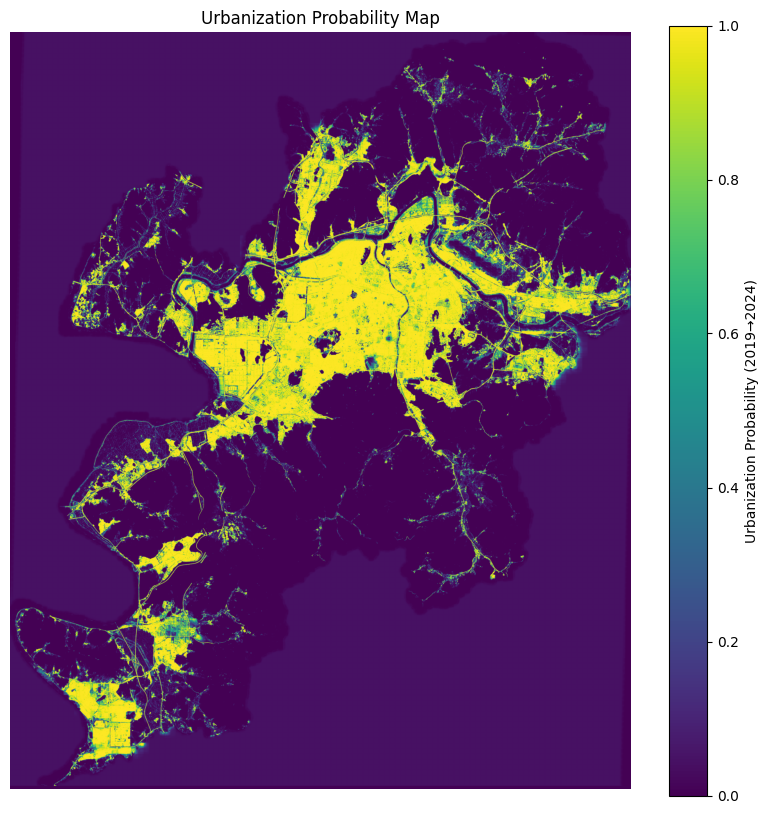

In [54]:
plt.figure(figsize=(10, 10))
plt.imshow(prob, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label="Urbanization Probability (2019→2024)")
plt.title("Urbanization Probability Map")
plt.axis("off")
plt.show()


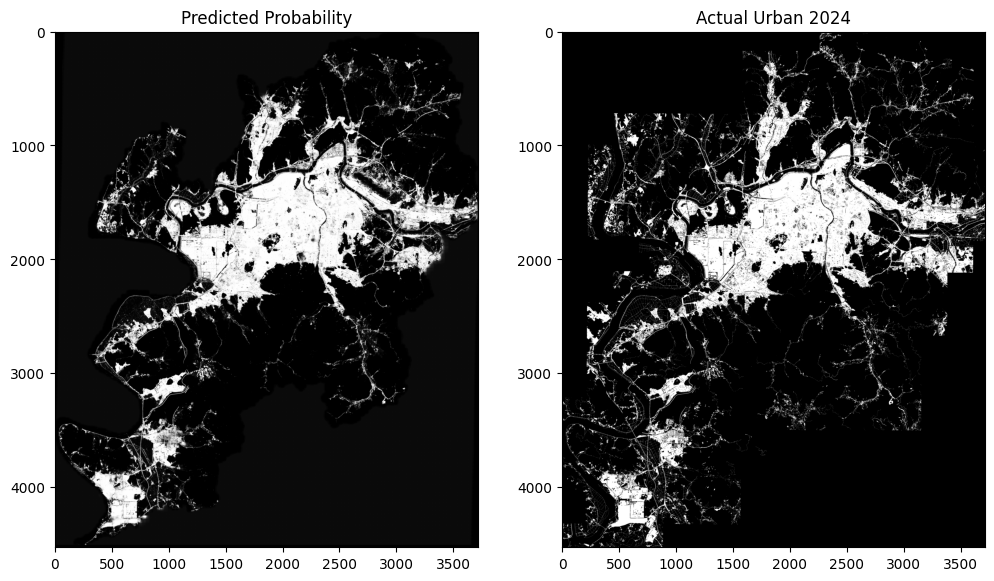

In [57]:
urban2024_path = "/content/drive/MyDrive/12-training-data/input/dependent-data-urban-no/urban_2024.tif"

with rasterio.open(urban2024_path) as src:
    urban24 = src.read(1)

plt.figure(figsize=(12, 12))
plt.subplot(1,2,1)
plt.imshow(prob, cmap='gray', vmin=0, vmax=1)
plt.title("Predicted Probability")

plt.subplot(1,2,2)
plt.imshow(urban24, cmap='gray')
plt.title("Actual Urban 2024")

plt.show()
